In [ ]:
!pip install tensorflow-addons

In [ ]:
from io import BytesIO
from base64 import b64decode
from google.colab import output
from IPython.display import Javascript
from librosa import display as disp
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa
import numpy as np
from tensorflow import keras
from tensorflow_addons.layers import AdaptiveAveragePooling2D

In [ ]:
RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec):
  print("Speak Now...")
  display(Javascript(RECORD))
  sec += 1
  s = output.eval_js('record(%d)' % (sec*1000))
  print("Done Recording !")
  b = b64decode(s.split(',')[1])
  return b #byte stream

In [ ]:
audio = record(5)   # will record for 7 seconds

Speak Now...


<IPython.core.display.Javascript object>

Done Recording !


In [ ]:
ipd.display(ipd.Audio(audio))

In [ ]:
with open('test_audio.wav', mode='bx') as f:
    f.write(audio)

In [ ]:
filename = '/content/test_audio.wav'
y, sr = librosa.load(filename, sr=None)
print(sr)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


48000


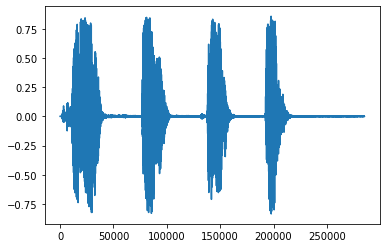

In [ ]:
plt.plot(y)
plt.show()

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1642: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  "amplitude_to_db was called on complex input so phase "


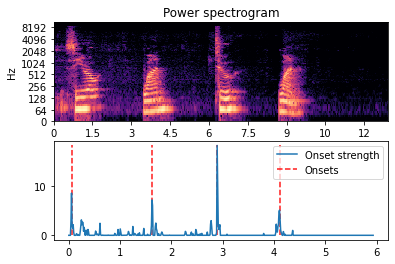

In [ ]:
o_env = librosa.onset.onset_strength(y=y, sr=sr,
                                         hop_length=512,
                                         aggregate=np.median)
times = librosa.frames_to_time(np.arange(len(o_env)), sr=sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr, wait=100, delta=0.20)

D = librosa.stft(y)
plt.figure()
ax1 = plt.subplot(2, 1, 1)
disp.specshow(librosa.amplitude_to_db(D, ref=np.max),
                      x_axis='time', y_axis='log')
plt.title('Power spectrogram')
plt.subplot(2, 1, 2)#, sharex=ax1)
plt.plot(times, o_env, label='Onset strength')
plt.vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
        linestyle='--', label='Onsets')
plt.axis('tight')
plt.legend(frameon=True, framealpha=0.75)
plt.show()

In [ ]:
frames = times[onset_frames]*sr

In [ ]:
print('length:  ', len(y))
print('sr:  ', sr)
print('seconds: ', len(y)/sr)

length:   285120
sr:   48000
seconds:  5.94


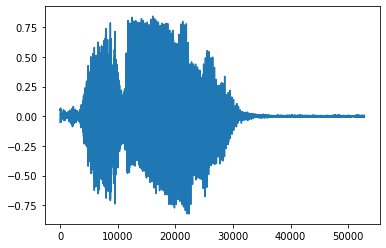

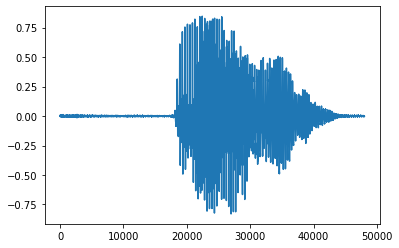

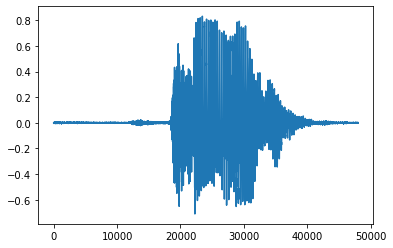

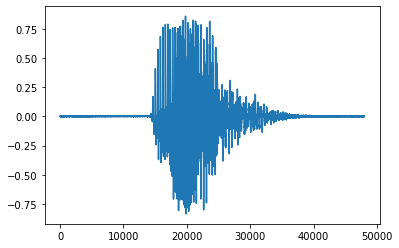

In [ ]:
digits = []

for frame in frames:
  if int(frame-sr*0.2) < 0:
    min=int(frame+0.1*sr)
    max=int(frame+1.2*sr)
  else:
    min=int(frame-sr*0.4)
    max=int(frame+sr*0.6)
  aux_y = y[min:max]
  digits.append(aux_y)
  plt.plot(aux_y)
  plt.show()

In [ ]:
n_fft = 1024
hop_length = 256
n_mels = 40
f_min = 20
f_max = 8000
sample_rate = 16000

In [ ]:
for count, digit in enumerate(digits):
  data, sr = (digit, sr)
    
  fig = plt.figure(figsize=[1,1])
  ax = fig.add_subplot(111)
  ax.axes.get_xaxis().set_visible(False)
  ax.axes.get_yaxis().set_visible(False)
  ax.set_frame_on(False)
    
  S = librosa.feature.melspectrogram(y=data, sr=sr)
  librosa.display.specshow(librosa.power_to_db(S, ref=np.max), x_axis='time', y_axis='mel', fmin=f_min, fmax=f_max)
  newfile  = '/content/spokendigits/'+ str(count) + '.jpg'
  plt.savefig(newfile, dpi=500, bbox_inches='tight',pad_inches=0)
  plt.close()

In [ ]:
model = keras.models.load_model('lifas-cnn-Adam-96.h5', custom_objects={'Addons>AdaptiveAveragePooling2D': AdaptiveAveragePooling2D})

dir = '/content/spokendigits/'
batch_size = 32
img_height = 256
img_width = 256

test_ds = keras.preprocessing.image_dataset_from_directory(
  dir,
  label_mode=None,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=False)

predictions = np.argmax(model.predict(test_ds),axis=1)
print(predictions)

Found 4 files belonging to 1 classes.
[0 1 2 1]


In [ ]:
digits_labels = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
results = [digits_labels[i] for i in predictions]

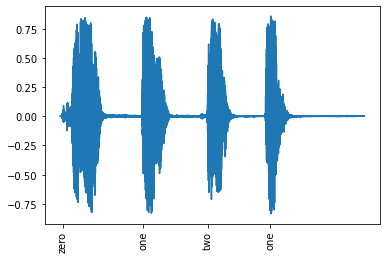

In [ ]:
plt.plot(y)
plt.xticks(frames, results, rotation='vertical')
plt.show()